# HCI VISUALIZATION

In [74]:
import pandas as pd
import numpy as np
import ast
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

# Load Datasets (Assuming files are in the current directory)
# Loading only essential columns for the 'heavy' files to save RAM
# Note: 'ast' will be used later to parse stringified lists in several columns
anime_details_df = pd.read_csv('datasets/details_cleaned.csv')
profiles_df = pd.read_csv('datasets/profiles_cleaned.csv')
ratings_df = pd.read_csv('datasets/ratings_cleaned.csv', usecols=['username', 'anime_id', 'score']) 
person_voice_works_df = pd.read_csv('datasets/person_voice_works_cleaned.csv')

# We convert dates to datetime immediately for time-series analysis
anime_details_df['start_date'] = pd.to_datetime(anime_details_df['start_date'], errors='coerce')
anime_details_df['start_year'] = anime_details_df['start_date'].dt.year

print("Data Loaded Successfully")

Data Loaded Successfully


In [75]:
# Drop rows where 'start_year' is missing (crucial for timeline analysis)
anime_clean = anime_details_df.dropna(subset=['start_year']).copy()

# Explode Genres
# The 'genres' column is a string like "Action, Comedy". We explode it.
# This increases the number of rows, so we save it as a separate DF for genre analysis.
anime_genres = anime_clean.assign(genres=anime_clean['genres'].apply(ast.literal_eval).explode('genres'))

# Explode 'studios' and take the first studio if multiple exist
# The studios column is stored as a stringified list; ast.literal_eval converts it to a list
anime_clean['studios'] = anime_clean['studios'].apply(ast.literal_eval)
# We treat the first listed studio as the primary studio for each anime
anime_clean['primary_studio'] = anime_clean['studios'].str[0]


print("Data Cleaned. Ready for Analysis.")

Data Cleaned. Ready for Analysis.


In [76]:
# CLEANING THE YEARS
# Ensure start_year is numeric and remove missing values
anime_clean = anime_clean.dropna(subset=['start_year'])
anime_clean['start_year'] = anime_clean['start_year'].astype(int)

# There are too many genres to plot them all. Let's keep only the Top 10 most popular.
top_genres = anime_genres['genres'].value_counts().head(10).index
filtered_data = anime_genres[anime_genres['genres'].isin(top_genres)]

# AGGREGATION 
# We group by Year and Genre to get the count
genre_trends = filtered_data.groupby(['start_year', 'genres']).size().reset_index(name='count')

# Create an interactive Line Chart
fig_volume = px.line(
    genre_trends,
    x='start_year',
    y='count',
    color='genres',
    title='A. Trends Over the Years: Evolution of Anime Production by Genre',
    labels={'start_year': 'Year', 'count': 'Number of Anime Produced', 'genres': 'Genre'},
    template="plotly_dark" # Optional: Looks good for anime themes
)

# Refine the layout to handle the x-axis range better
fig_volume.update_xaxes(range=[1960, 2024]) # Focus on the modern era
fig_volume.show()

Questo grafico a linee è interattivo e permette all'utente di selezionare quali generi visualizzare o nascondere e di zoomare sui trend,. L'interattività è cruciale in questo tipo di visualizzazione [A. Trenads Over the Years], specialmente quando si devono confrontare molti generi contemporaneamente.

### The Rise and Fall of Genres
Have audience preferences shifted?
Are we moving away from the classic "Mecha" and "Sci-Fi" eras towards "Slice of Life" or "Isekai" trends?

Visualization: We use a Heatmap (Seaborn) to visualize the average score of top genres over decades. This allows us to see not just what is produced, but what is rated highly.

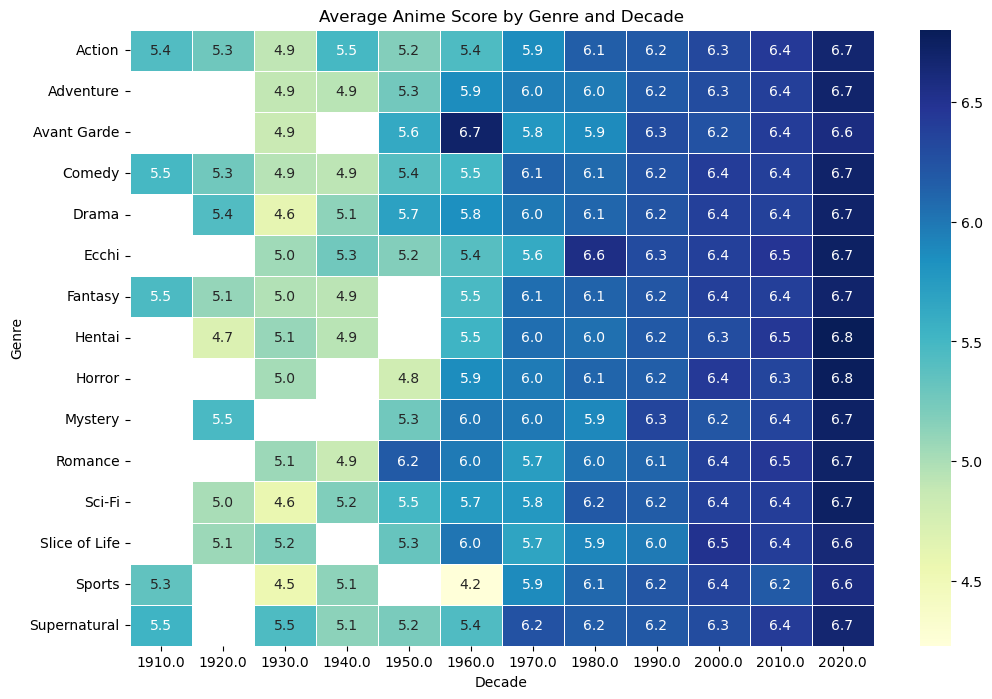

In [77]:
# Select top 15 genres by total frequency to keep the chart readable
top_genres = anime_genres['genres'].value_counts().head(15).index

# Filter the genre dataframe (make a copy to avoid SettingWithCopy warnings)
genre_trend = anime_genres[anime_genres['genres'].isin(top_genres)].copy()

# Create a 'decade' column for aggregation
genre_trend['decade'] = (genre_trend['start_year'] // 10) * 10

# Pivot table: Index=Genres, Columns=Decade, Values=Mean Score
# This produces the matrix used by the heatmap to show score trends over decades
heatmap_data = genre_trend.pivot_table(index='genres', columns='decade', values='score', aggfunc='mean')

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=.5)
plt.title("Average Anime Score by Genre and Decade")
plt.xlabel("Decade")
plt.ylabel("Genre")
plt.show()


Although the heatmap shows values starting from the 1910s, these are not errors: the dataset really includes a handful of very early Japanese animated productions. These decades contain very few titles compared to modern years, so their averages should be interpreted cautiously. However, instead of removing them, I decided to keep them because they provide historical context and show how the medium truly evolves from its earliest experimental works to today’s large-scale industry.

Now we question ourselves how productions and studios are related

In [78]:
# Drop rows where there is no primary studio
anime_studios = anime_clean[anime_clean['primary_studio'].notna()].copy()

# Aggregation: Count productions and calculate mean score
studio_stats = anime_studios.groupby('primary_studio').agg(
    production_count=('mal_id', 'count'),
    avg_score=('score', 'mean'),
    total_favorites=('favorites', 'sum')
).reset_index()

# Filter: Only keep studios with > 20 productions to avoid noise
top_studios = studio_stats[studio_stats['production_count'] > 20]

# --- TREEMAP (Market Share) ---
fig_tree = px.treemap(
    top_studios,
    path=[px.Constant("All Studios"), 'primary_studio'],
    values='production_count',
    color='avg_score',
    color_continuous_scale='RdBu',  # Red = Bad, Blue = Good
    title='Studio Dominance: Box Size = Production Volume, Color = Average Score',
    hover_data=['avg_score']
)
fig_tree.update_layout(margin=dict(t=50, l=25, r=25, b=25))
fig_tree.show()


The treemap shows that a few giant studios like Toei Animation, Sunrise, J.C. Staff and TMS Entertainment dominate anime production volume, but high output doesn’t automatically mean higher quality—some smaller studios (e.g., Bones, Kyoto Animation, Madhouse) achieve higher average scores with fewer titles, suggesting more consistent critical success.

### "Who is the 'Prestige' studio?"

In [79]:
top_studios = top_studios.copy()

# pick top 20 by favorites (change column if you want)
top20_idx = top_studios.nlargest(20, "total_favorites").index

# create labels for only the top 20 studios
top_studios["label"] = ""
top_studios.loc[top20_idx, "label"] = top_studios.loc[top20_idx, "primary_studio"]

# --- SCATTER (Quality vs Quantity) ---
fig_scatter = px.scatter(
    top_studios,
    x="production_count",
    y="avg_score",
    size="total_favorites",
    text="label",
    title="Studio Strategy: Quality (Y) vs. Quantity (X)",
    labels={
        "production_count": "Total Anime Produced",
        "avg_score": "Average Score"
    },
    height=600
)

fig_scatter.update_traces(
    mode="markers+text",
    textposition="top center",
    textfont=dict(size=12)
)

fig_scatter.show()

Studios that make tons of anime don’t always make the best ones. Big producers like J.C. Staff, Studio Pierrot, and TMS release a huge number of shows, but their average ratings are just “good.” Meanwhile, studios like Kyoto Animation, Bones, Wit Studio, CloverWorks, and ufotable produce fewer titles but usually get higher scores. The bubble size also matters: it represents how many users marked those shows as favorites. This means the “quality-first” studios don’t just score well — their anime are also loved more by fans.

### How many users do we have around the world?

In [80]:
# Count users per country
country_counts = profiles_df['location'].value_counts().reset_index()
country_counts.columns = ['location', 'User_Count']

# Use gapminder to map country names to ISO-3 codes required by plotly
codes = px.data.gapminder()[["country", "iso_alpha"]].drop_duplicates()

country_counts = country_counts.merge(codes, left_on="location", right_on="country", how="left")

fig = px.choropleth(
    country_counts,
    locations="iso_alpha",
    locationmode="ISO-3",
    color="User_Count",
    hover_name="location",
    color_continuous_scale=px.colors.diverging.Portland,
    title="User Distribution by Extracted Location"
)

fig.update_layout(
    margin=dict(l=0, r=0, t=40, b=0),
    geo=dict(
        projection_scale=1.1,
        center=dict(lat=0, lon=0)
    ),
    width=1100,
    height=650
)

fig.show()


Separating japan won't make much difference in this graph.
We could check whether this map changes if we count the percentage of people watch anime compared to the whole population of the country

In [81]:
# 1. Count users per country (from your dataset)
country_counts = profiles_df['location'].value_counts().reset_index()
country_counts.columns = ['location', 'User_Count']

# 2. Get population + ISO-3 codes from gapminder
gap = px.data.gapminder()[['country', 'iso_alpha', 'year', 'pop']]

# take the latest year per country
gap_latest = gap.sort_values('year').drop_duplicates('country', keep='last')

# 3. Merge your counts with population data
country_counts = country_counts.merge(
    gap_latest,
    left_on='location',   # my country names
    right_on='country',   # gapminder country names
    how='left'
)

# 4. Compute users percentage
country_counts['users_percent'] = (country_counts['User_Count'] / country_counts['pop'] * 100)

# 5. Plot: anime users normalized by population
fig = px.choropleth(
    country_counts,
    locations="iso_alpha",
    locationmode='ISO-3',
    color="users_percent",
    hover_name="location",
    hover_data={
        "User_Count": True,
        "pop": True,
        "users_percent": ':.2f'
    },
    color_continuous_scale=px.colors.diverging.Portland,
    title='Anime Users per 100k Inhabitants by Country'
)

fig.update_layout(
    margin=dict(l=0, r=0, t=40, b=0),
    geo=dict(
        projection_scale=1.1,
        center=dict(lat=0, lon=0)
    ),
    width=1100,
    height=650
)

fig.show()


This way we can tell Australia becomes much more interesting.
Though we could use a logarithmic scale in order to visualize better the differences between other countries too.

In [82]:
# 1. Count users per country (from your dataset)
country_counts = profiles_df['location'].value_counts().reset_index()
country_counts.columns = ['location', 'User_Count']

# 2. Get population + ISO-3 codes from gapminder
gap = px.data.gapminder()[['country', 'iso_alpha', 'year', 'pop']]

# take the latest year per country
gap_latest = gap.sort_values('year').drop_duplicates('country', keep='last')

# 3. Merge your counts with population data
country_counts = country_counts.merge(
    gap_latest,
    left_on='location',   # my country names
    right_on='country',   # gapminder country names
    how='left'
)

# 4. Compute users percentage
country_counts['users_percent'] = (
    country_counts['User_Count'] / country_counts['pop'] * 100
)

country_counts['users_percent_log'] = np.log10(country_counts['users_percent'].replace(0, np.nan))


# 5. Plot: anime users normalized by population
fig = px.choropleth(
    country_counts,
    locations="iso_alpha",
    locationmode='ISO-3',
    color="users_percent_log",
    hover_name="location",
    hover_data={
        "User_Count": True,
        "pop": True,
        "users_percent": ':.2f'
    },
    color_continuous_scale=px.colors.diverging.Portland,
    title='Anime Users per 100k Inhabitants by Country'
)

fig.update_layout(
    margin=dict(l=0, r=0, t=40, b=0),
    geo=dict(
        projection_scale=1.1,  # zoom in slightly
        center=dict(lat=0, lon=0)
    ),
    width=1100,
    height=650
)

fig.show()

From the previous graph we couldn't tell exactly which were the countries the least percentage of users.
With the logarithmic scale we can tell India has the least amount of people (compared to its own population) watching anime, followed by China and then Indonesia and Brasil on the same level.

### Let's check for the average score anime get

In [83]:
avg_rating = anime_details_df['score'].mean()

fig = go.Figure(go.Indicator(
    mode = "gauge+number",
    value = avg_rating,
    title = {'text': "Average Anime Score"},
    gauge = {'axis': {'range': [1, 10]},
             'bar': {'color': "darkblue"},
             'steps': [
                 {'range': [1, 5], 'color': "red"},
                 {'range': [5, 7], 'color': "yellow"},
                 {'range': [7, 10], 'color': "green"}]}
))
fig.show()

### Let's see how international the voice acting database is.

In [84]:
# Count distinct roles by language
lang_counts = person_voice_works_df['language'].value_counts().reset_index()
lang_counts.columns = ['language', 'role_count']

fig = px.bar(
    lang_counts.head(10),
    x='role_count',
    y='language',
    orientation='h',
    title='Voice Acting Languages in Anime (Top 10 Including Japanese)',
    color='role_count',
    color_continuous_scale='Viridis'
)
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()


#### Now let's check without the japanese, or using a logarithmic scale

In [85]:
fig = px.bar(
    lang_counts.head(10), 
    x='role_count',
    y='language',
    orientation='h',
    title='Voice Acting Languages (Log Scale)',
    color='role_count',
    color_continuous_scale='Viridis'
)

fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.update_xaxes(type='log')
fig.show()


In [86]:
# Separate Japanese (Dominant) from Others to make the chart readable
non_jp = lang_counts[lang_counts['language'] != 'Japanese']

# --- PLOT ---
fig = px.bar(
    non_jp.head(10), # Top 10 non-Japanese languages
    x='role_count',
    y='language',
    orientation='h',
    title='Globalization of Anime: Top Non-Japanese Voice Acting Languages',
    color='role_count',
    color_continuous_scale='Viridis'
)
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.update_xaxes(type='log')

fig.show()

### Anime reaches the global West through Licensors. Who owns the market?

In [87]:
# Explode Licensors into separate rows so each licensor can be counted individually
anime_lic = anime_clean.assign(licensors=anime_clean['licensors'].apply(ast.literal_eval)).explode('licensors')

# Remove Unknown / None
anime_lic = anime_lic[anime_lic['licensors'].notna()]

# Count occurrences per licensor
licensor_counts = anime_lic['licensors'].value_counts().reset_index()
licensor_counts.columns = ['Licensor', 'Count']

# PLOT ALL LICENSORS (no grouping)
fig = px.pie(
    licensor_counts,
    values='Count',
    names='Licensor',
    title='Market Share of All Anime Licensors',
    hole=0.4
)

fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()


This Pie Chart doesn't work because we have too many licensors, we could use a Treemap instead

In [88]:
# Treemap of licensors
fig = px.treemap(
    licensor_counts,
    path=['Licensor'],
    values='Count',
    title='Anime Licensors – Market Share (Treemap)'
)

fig.update_traces(textinfo="label+percent entry")
fig.show()


A few big names like Funimation and Sentai Filmworks take a huge chunk of the market, while most other licensors only handle a very small share. So even though there are many companies in the space, real “power” is mostly in the hands of just a handful of them.

### When are our users born? Is there any difference in rating by age?

In [89]:
# Birthday extraction
profiles_df['birthday'] = pd.to_datetime(profiles_df['birthday'], errors='coerce')
profiles_df['bday_year'] = profiles_df['birthday'].dt.year

# Compute average score per user BUT only valid scores 1–10
valid_ratings = ratings_df[ratings_df['score'].between(1, 10)]
avg_user_score = (valid_ratings.groupby('username')['score'].mean().reset_index())

# Merge
user_history = pd.merge(profiles_df[['username', 'bday_year']],avg_user_score,on='username',how='inner')

# Group
cohort_analysis = (user_history.groupby('bday_year')['score'].agg(avg_score='mean', users='count').reset_index())
cohort_analysis = cohort_analysis[cohort_analysis['users'] >= 50]

# --- PLOT ---
fig = px.line(
    cohort_analysis,
    x='bday_year',
    y='avg_score',
    markers=True,
    title='Do Different Age Cohorts Rate Differently?',
    labels={'bday_year': 'Birth Year', 'avg_score': 'Average Score Given'}
)

fig_users = px.bar(
    cohort_analysis,
    x='bday_year',
    y='users',
    title='Users Per Birth Year Cohort'
)
fig_users.show()
fig.show()

Looking only at cohorts with enough users to be meaningful, we find that:

1985–1995 cohorts
Average ratings are fairly stable around ~7.6–7.7, suggesting consistent, balanced rating behavior.

Late 1990s → Early 2000s cohorts
There is a gradual decline toward ~7.4–7.5.
Possible explanation: these users rate more shows, including mid-tier titles, and MAL became mainstream in their era → broader viewing → slightly harsher averages.

Post-2008 cohorts
Scores jump upward again. This could reflect: fewer users, tendency to rate only popular modern titles or younger users being more enthusiastic.

### Does user gender make any difference when giving the score to an anime?

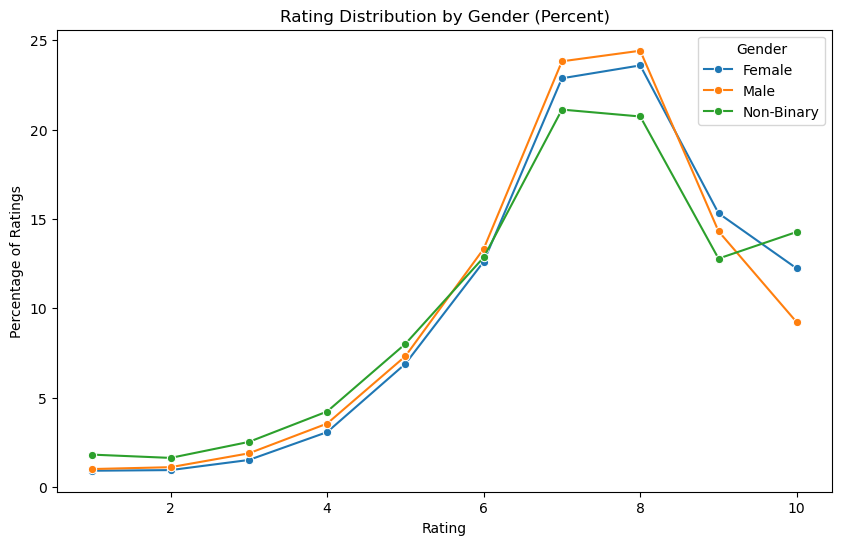

In [90]:
# Make sure score is numeric
ratings_df["score"] = pd.to_numeric(ratings_df["score"], errors="coerce")

# Merge ratings + profiles to attach gender to each rating so we can analyze by gender
merged_df = ratings_df.merge(
    profiles_df[["username", "gender"]],
    on="username",
    how="inner"
)

# Keep valid data
merged_df = merged_df[
    merged_df["gender"].notna() &
    merged_df["score"].between(1, 10)
]

counts = (
    merged_df
    .groupby(['gender','score'])
    .size()
    .reset_index(name='count')
)

# compute total ratings per gender
totals = counts.groupby('gender')['count'].transform('sum')

# create percent col
counts['percent'] = counts['count'] / totals * 100

rating_dist = counts

plt.figure(figsize=(10,6))
sns.lineplot(
    data=rating_dist,
    x='score',
    y='percent',
    hue='gender',
    marker='o'
)

plt.title('Rating Distribution by Gender (Percent)')
plt.xlabel('Rating')
plt.ylabel('Percentage of Ratings')
plt.legend(title='Gender')
plt.show()


We used to percentages instead of raw counts so we could compare how each gender actually rates, instead of just seeing which group has more people in it.
All genders rate pretty similarly overall, with most ratings clustered around 7 and 8. It looks like non-binary users show a bit more “spread”, giving both more low scores and more 10s compared to the others, while males and females look slightly more conservative around the middle.

These differences should be interpreted with caution, as gender groups are not equally represented in the dataset.

### How did the different types of anime formats change over time?

In [91]:
# Aggregate: Count by Year and Type
format_counts = anime_clean.groupby(['start_year', 'type']).size().reset_index(name='count')
format_counts = format_counts[(format_counts['start_year'] >= 1960) & (format_counts['start_year'] <= 2025)]

# Calculate Percentage per Year (Vectorized)
# We merge the yearly totals back to calculate the share
yearly_totals = format_counts.groupby('start_year')['count'].transform('sum')
format_counts['share'] = format_counts['count'] / yearly_totals

# --- PLOT ---
fig = px.area(
    format_counts,
    x="start_year",
    y="share",
    color="type",
    title="Evolution of Anime Release Formats",
    labels={'share': 'Market Share', 'start_year': 'Year'},
)
fig.show()

The industry basically moved from “buy this on DVD/VHS” to “watch it online whenever you want.” OVAs were huge back when home video was the big thing, especially in the late 80s and 90s, but they slowly faded as discs stopped mattering. Meanwhile, ONAs exploded thanks to streaming platforms, YouTube, Netflix and so on, becoming one of the main ways anime gets released today. TV is still important and steady, but this chart really shows how technology changed where anime comes out and how people watch it.

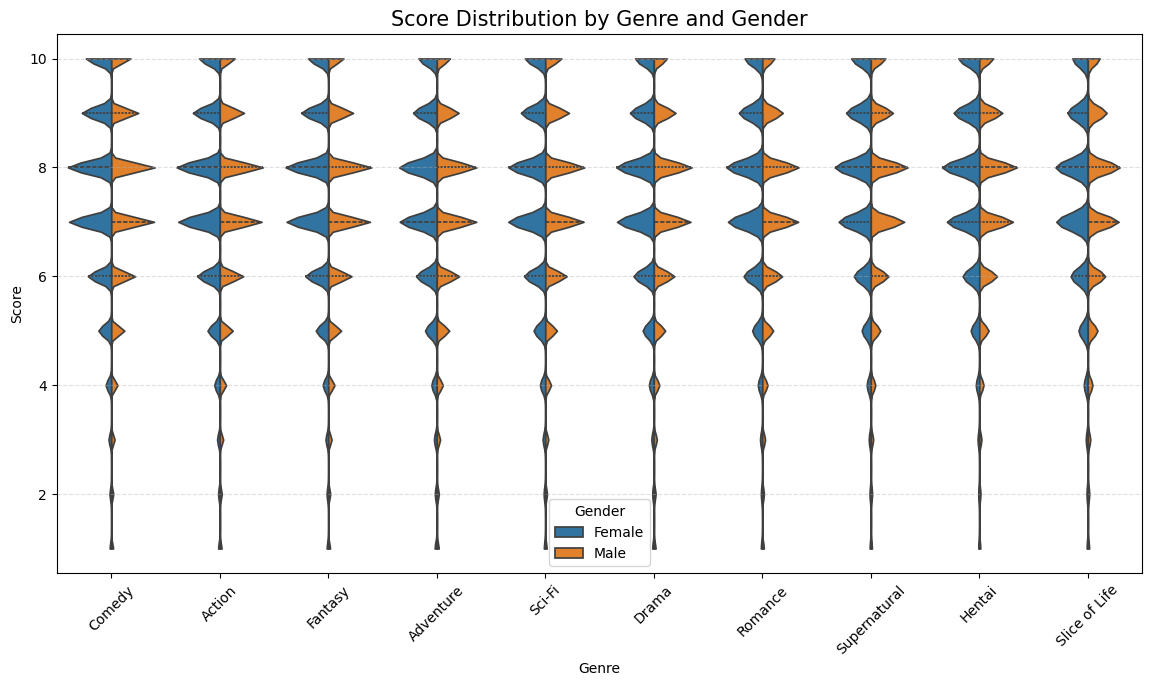

In [92]:
# Filter profiles for gender (Male/Female only for binary comparison)
users = profiles_df[profiles_df['gender'].isin(['Male', 'Female'])][['username', 'gender']]

# Merge Ratings with Users (full dataset, scores > 0 only)
valid_ratings = ratings_df[ratings_df['score'] > 0]
user_ratings = pd.merge(valid_ratings, users, on='username', how='inner')

# Merge with Anime to get Genres
# We need to use the exploded 'anime_genres', but just the ID and Genre columns
anime_genre_map = anime_genres[['mal_id', 'genres', 'title']]
full_data = pd.merge(user_ratings, anime_genre_map, left_on='anime_id', right_on='mal_id', how='inner')

# Choose an order: top 10 most rated genres in this merged dataset
genre_order = (
    full_data['genres']
    .value_counts()
    .head(10)
    .index
    .tolist()
)
# Keep only those genres from the full rating data
full_data_top = full_data[full_data['genres'].isin(genre_order)]

# --- VIOLIN PLOT ---
plt.figure(figsize=(14, 7))
sns.violinplot(
    data=full_data_top,
    x='genres',
    y='score',
    hue='gender',
    order=genre_order,
    split=True,
    inner='quartile',
    cut=0
)
plt.xticks(rotation=45)
plt.title("Score Distribution by Genre and Gender", fontsize=15)
plt.xlabel("Genre")
plt.ylabel("Score")
plt.legend(title="Gender")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()


We first tried to use a violin plot to compare scores by gender. When all three gender categories were included, the chart became messy and hard to read, so we decided to focus only on Male and Female users, since they make up most of the dataset.
Non-binary users are still included in the data overall, but weren't used in this specific visualization because there are fewer of them and the plot would have become confusing.

From the violin plot we can see that male and female users rate anime in a very similar way. Most ratings for both genders stay between 6 and 9, and the shapes overlap a lot. This means gender doesn’t seem to strongly influence how people rate anime in general.

### How big is the gap between male and female when it comes to rating specific genres?

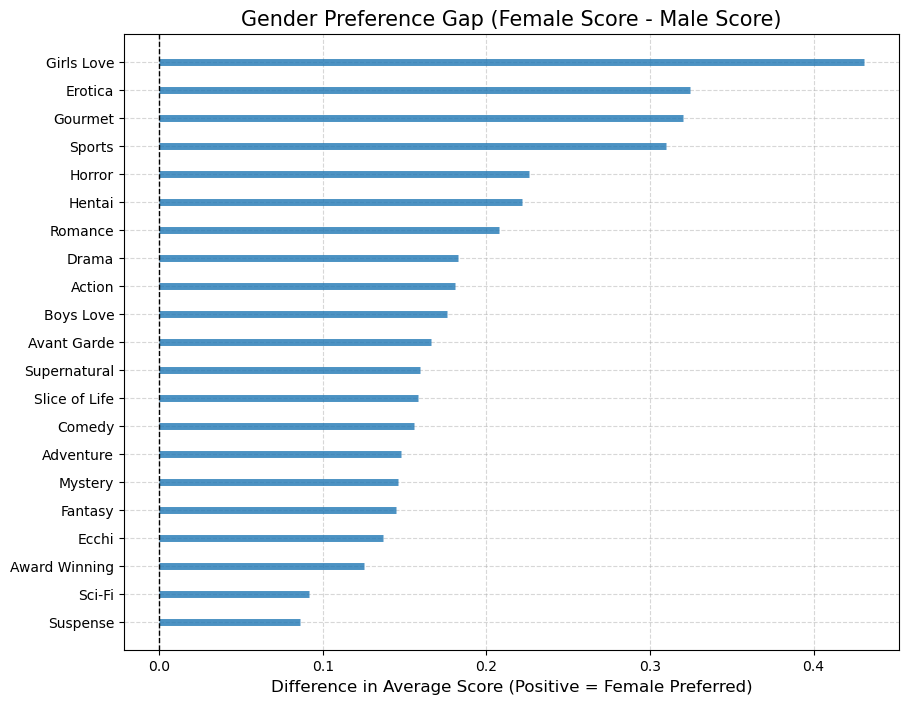

In [93]:
#Using the same data we just computed, we could now visualize the gender preference gap.

# Aggregation: Mean score per Genre per Gender (unstack is used to pivot gender into columns)
# This results in a table where each row is a genre and columns are genders with mean scores
genre_gender_scores = full_data.groupby(['genres', 'gender'])['score'].mean().unstack()

# Calculate Gap and Filter for Top Genres
comparison = genre_gender_scores.loc[genre_gender_scores.index].copy()
comparison['diff'] = comparison['Female'] - comparison['Male']
comparison = comparison.sort_values('diff')

# Order genres by the same gap used above
genre_order = comparison.index.tolist()

# --- GAP PLOT  ---
plt.figure(figsize=(10, 8))
plt.hlines(
    y=comparison.index,
    xmin=0,
    xmax=comparison['diff'],
    color='C0',
    alpha=0.8,
    linewidth=5
)
plt.axvline(0, color='black', linestyle='--', linewidth=1) 
plt.title("Gender Preference Gap (Female Score - Male Score)", fontsize=15)
plt.xlabel("Difference in Average Score (Positive = Female Preferred)", fontsize=12)
plt.grid(linestyle='--', alpha=0.5)
plt.show()


When we zoom in on the difference in average scores, the gap plot shows that, on average, female users tend to rate slightly higher than male users across almost all genres. The difference is small but consistent, meaning women are usually just a bit more positive when giving scores compared to men.

### What's the rating distribution of the Top 10 Anime?

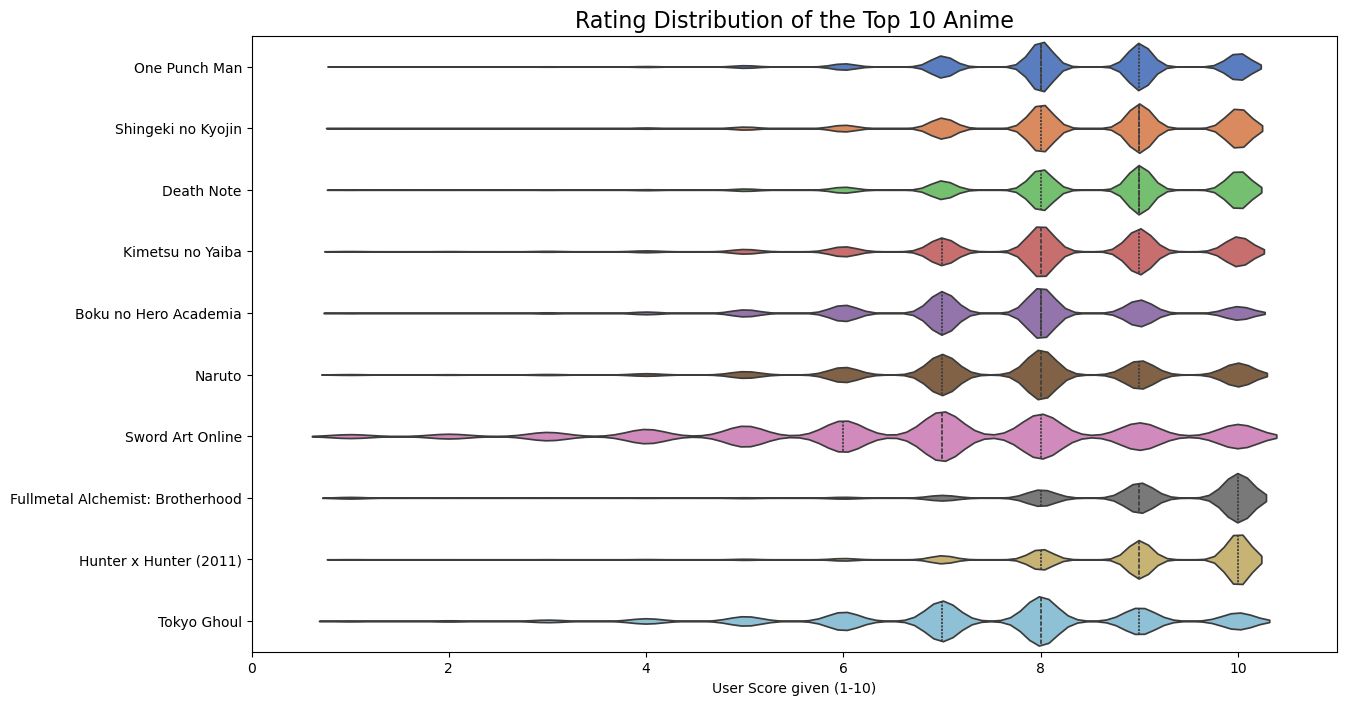

In [94]:
# Identify the Top 10 Most Watched Anime
top_10_ids = anime_clean.nlargest(10, 'members')['mal_id']
top_10_titles = anime_clean.set_index('mal_id').loc[top_10_ids, 'title']

# Filter ratings_df
# Ideally, you do this merge carefully.
top_ratings = ratings_df[ratings_df['anime_id'].isin(top_10_ids)].copy()

# Add Titles for the plot
top_ratings['anime_title'] = top_ratings['anime_id'].map(top_10_titles)

# Filter out ratings with a score of 0
top_ratings = top_ratings[top_ratings['score'] != 0]

# --- PLOT ---
plt.figure(figsize=(14, 8))
sns.violinplot(
    data=top_ratings,
    x='score',
    y='anime_title',
    density_norm='width',
    hue="anime_title",
    palette='muted',
    inner='quartile' # Show the median and quartiles inside
)

plt.title("Rating Distribution of the Top 10 Anime", fontsize=16)
plt.xlabel("User Score given (1-10)")
plt.ylabel("")
plt.xlim(0, 11) # Scores are 1-10
plt.show()

Some top anime are “universally loved” with ratings clustered around 9–10 (like Fullmetal Alchemist: Brotherhood, Hunter x Hunter, Shingeki no Kyojin), while others are far more divisive, showing wide spreads across all scores (like Sword Art Online, Tokyo Ghoul, and Naruto).

### Anime has 4 main target demographics: Shounen (Boys), Shojo (Girls), Seinen (Adult Men), Josei (Adult Women). 
Which one actually produces the highest-rated content?

In [95]:
# Explode demographics
anime_demographics = anime_clean.assign(demographics=anime_clean["demographics"].apply(ast.literal_eval).explode("demographics"))

# Drop missing demographics
anime_demographics = anime_demographics[anime_demographics["demographics"].notna()]

# Plot
fig = px.box(
    anime_demographics,
    x="demographics",
    y="score",
    color="demographics",
    title="Target Audience vs. Critical Acclaim",
    points="suspectedoutliers",
    category_orders={"demographics": ["Kids", "Shounen", "Shoujo", "Seinen", "Josei"]}
    )

fig.update_xaxes(title_text="Demographics (ordered by target age)")
fig.update_yaxes(title_text="Score")

fig.show()



Scores don’t change dramatically across demographics, but Kids anime clearly performs worse, while Seinen shows the largest variability with both more masterpieces and more flops.

### Are there any genre preferred from specific studios? Do they all produce the same genres?

In [96]:
# Top 10 studios
top_studios = anime_genres["primary_studio"].value_counts().head(10).index

# Filter only those studios
specialization_data = anime_genres[anime_genres["primary_studio"].isin(top_studios)]

# Top 10 genres (to keep readable)
specialization_data = specialization_data[specialization_data["genres"].isin(specialization_data["genres"].value_counts().head(10).index)]


# Pivot table (needed for the heatmap)
studio_genre_pivot = pd.crosstab(specialization_data["primary_studio"],specialization_data["genres"])

# --- HEATMAP ---
plt.figure(figsize=(12, 8))
sns.heatmap(
    studio_genre_pivot,
    annot=True,
    fmt="d",
    cmap="Purples",
    linewidths=.5
)

plt.title("Number of Productions by Genre", fontsize=14)
plt.ylabel("Studio")
plt.xlabel("Genre")
plt.show()


KeyError: 'primary_studio'

The heatmap shows that studios aren’t all doing the same thing—most of them have clear comfort zones. Toei lives in Action/Adventure, Sunrise is basically a Sci-Fi machine, and J.C. Staff + TMS carry Comedy. Meanwhile Madhouse spreads across everything, but still leans toward Drama/Fantasy. In short: the anime industry is full of ‘specialist studios’ instead of generalists.

### Are there any hidden gems?
Let's look for shows that are amazing (High Score) but ignored (Low Popularity).

In [ ]:
# Identify candidate 'hidden gems' — well-rated but not broadly popular shows
# We require a minimum number of members to avoid tiny-sample artifacts
gem_data = anime_clean[(anime_clean['score'] > 0) & (anime_clean['members'] > 1000)] # Minimum threshhold to be a "gem" not just a glitch   

# --- PLOT ---
fig = px.scatter(
    gem_data,
    x="members",
    y="score",
    color="type",
    hover_name="title",
    log_x=True, # Essential for popularity
    title="The Search for Hidden Gems (Top Left Quadrant)",
    labels={'members': 'Popularity (Log Scale)', 'score': 'Score'},
    height=700
)

# Add Quadrant Lines
# "Popularity" median and "Score" median
median_pop = gem_data['members'].median()
median_score = gem_data['score'].median()

fig.add_vline(x=median_pop, line_width=1, line_dash="dash", line_color="grey")
fig.add_hline(y=median_score, line_width=1, line_dash="dash", line_color="grey")

# Annotation
fig.add_annotation(
    x=np.log10(median_pop) - 0.5, # Adjusted for log scale visual placement
    y=median_score + 2.5,
    text="HIDDEN GEMS\\n(High Score, Low Pop)",
    showarrow=False,
    font=dict(color="green", size=14)
)

fig.show()


By plotting score vs popularity, we can visually search for “hidden gems”: anime that are rated very highly but haven’t reached mainstream popularity yet. The general trend shows that popularity and ratings roughly rise together, but the interesting part is the top-left quadrant: there are plenty of highly rated shows that relatively few people have watched — meaning there really are underrated masterpieces buried in the dataset.

### How many anime do people watch across their life?
Do older people still watch anime?

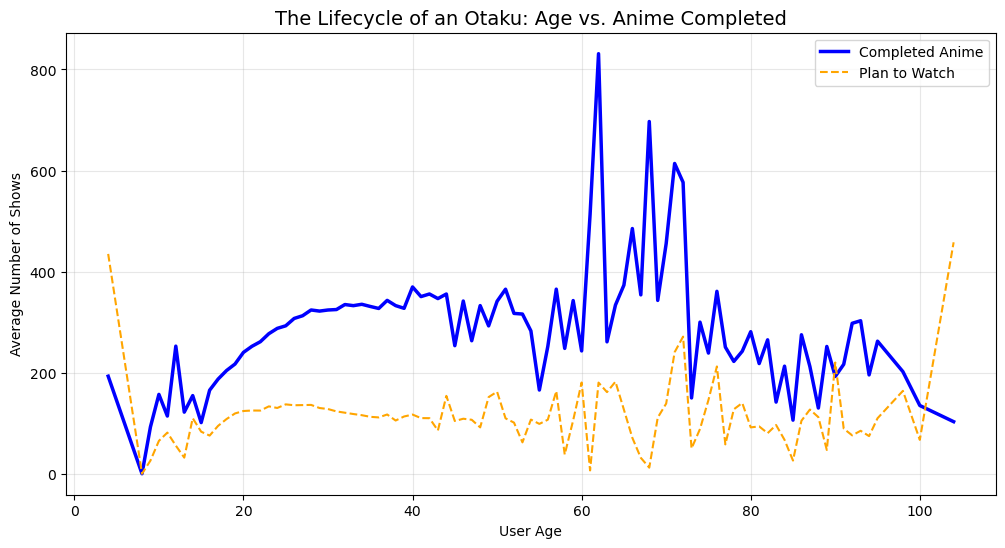

In [ ]:
# Convert birthday to datetime, coerce errors to NaT
profiles_df['birthday'] = pd.to_datetime(profiles_df['birthday'], errors='coerce')

# Calculate Age (Assuming dataset is current to ~2025)
# (Vectorized date math)
profiles_df['age'] = 2025 - profiles_df['birthday'].dt.year

profiles_df['completed'] = pd.to_numeric(profiles_df['completed'], errors='coerce')
profiles_df['plan_to_watch'] = pd.to_numeric(profiles_df['plan_to_watch'], errors='coerce')

# Group by Age and get average 'completed' anime
age_trends = profiles_df.groupby('age')[['completed', 'plan_to_watch']].mean().reset_index()

# --- PLOT ---
plt.figure(figsize=(12, 6))
sns.lineplot(data=age_trends, x='age', y='completed', label='Completed Anime', color='blue', linewidth=2.5)
sns.lineplot(data=age_trends, x='age', y='plan_to_watch', label='Plan to Watch', color='orange', linestyle='--')

plt.title("The Lifecycle of an Otaku: Age vs. Anime Completed", fontsize=14)
plt.ylabel("Average Number of Shows")
plt.xlabel("User Age")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

The spike in older ages isn’t a real trend: it happens because very few users list ages above 50, so some of older profiles make the average explode. We restricted analysis to well-represented age ranges to avoid wrong conclusions.
We try to avoid those spikes by filtering the age just where most of our data are (age 10 to 50)

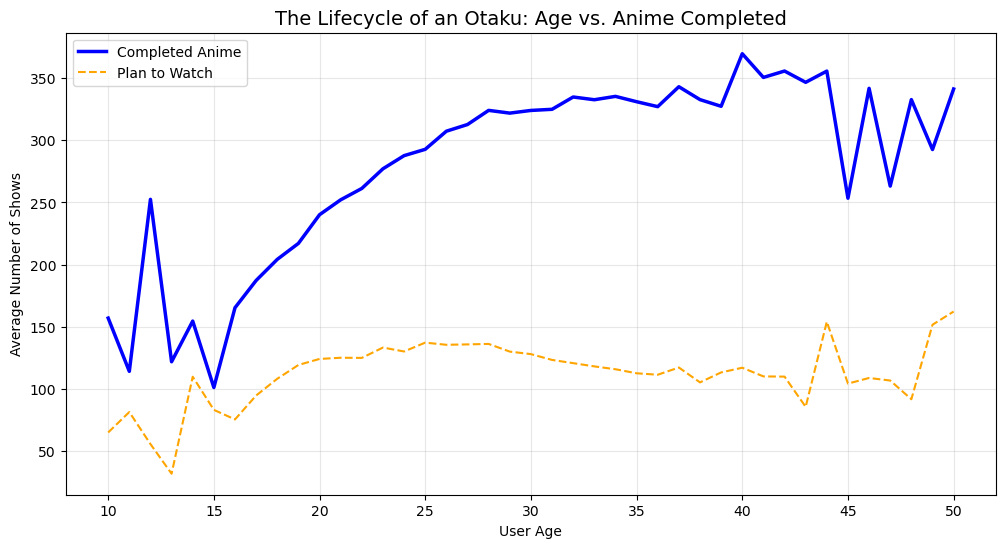

In [ ]:
# Convert birthday to datetime, coerce errors to NaT
profiles_df['birthday'] = pd.to_datetime(profiles_df['birthday'], errors='coerce')

# Calculate Age (Assuming dataset is current to ~2025)
profiles_df['age'] = 2025 - profiles_df['birthday'].dt.year

profiles_df['completed'] = pd.to_numeric(profiles_df['completed'], errors='coerce')
profiles_df['plan_to_watch'] = pd.to_numeric(profiles_df['plan_to_watch'], errors='coerce')

# Keep only reasonable ages
profiles_df = profiles_df[profiles_df['age'].between(10, 50)]

# Group by Age and get median values
age_trends = profiles_df.groupby('age')[['completed', 'plan_to_watch']].mean().reset_index()

# --- PLOT ---
plt.figure(figsize=(12, 6))
sns.lineplot(data=age_trends, x='age', y='completed',label='Completed Anime', color='blue', linewidth=2.5)
sns.lineplot(data=age_trends, x='age', y='plan_to_watch',label='Plan to Watch', color='orange', linestyle='--')

plt.title("The Lifecycle of an Otaku: Age vs. Anime Completed", fontsize=14)
plt.ylabel("Average Number of Shows")
plt.xlabel("User Age")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

Looking at the chart, younger users tend to watch more anime on average, steadily increasing through their teens and early adulthood. Once people hit their late 20s and 30s, the curve starts flattening or dropping slightly — probably because life kicks in (work, family, less free time). Interestingly, even if they slow down watching, their “Plan to Watch” list doesn’t disappear, meaning the passion stays even if time doesn’t.

To make the trend easier to read, we grouped ages into small buckets instead of using every single age. This smooths out random spikes and gives a clearer picture of how watching habits change with age.

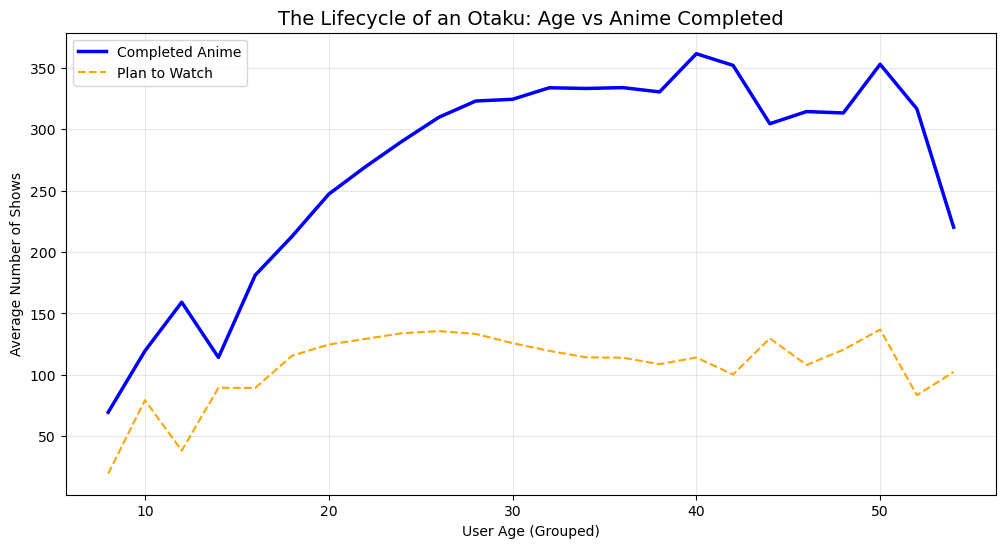

In [ ]:
# Convert birthday to datetime
profiles_df['birthday'] = pd.to_datetime(profiles_df['birthday'], errors='coerce')

# Calculate age
profiles_df['age'] = 2025 - profiles_df['birthday'].dt.year

profiles_df['completed'] = pd.to_numeric(profiles_df['completed'], errors='coerce')
profiles_df['plan_to_watch'] = pd.to_numeric(profiles_df['plan_to_watch'], errors='coerce')

# Keep reasonable ages
profiles_df = profiles_df[profiles_df['age'].between(10, 50)]

# ---- AGE BUCKETS ----
profiles_df['age_group'] = (profiles_df['age'] // 2) * 2   # groups like 12,14,16...

# Mean per bucket
age_trends = (
    profiles_df
    .groupby('age_group')[['completed', 'plan_to_watch']]
    .mean()
    .reset_index()
    .sort_values('age_group')
)

# ---- PLOT ----
plt.figure(figsize=(12,6))
sns.lineplot(data=age_trends, x='age_group', y='completed',
             label='Completed Anime', color='blue', linewidth=2.5)

sns.lineplot(data=age_trends, x='age_group', y='plan_to_watch',
             label='Plan to Watch', color='orange', linestyle='--')

plt.title("The Lifecycle of an Otaku: Age vs Anime Completed", fontsize=14)
plt.xlabel("User Age (Grouped)")
plt.ylabel("Average Number of Shows")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()



### Do real-world events change the number of anime in production?

In [ ]:
# Count anime starts per year
timeline = anime_clean['start_year'].value_counts().sort_index().reset_index()
timeline.columns = ['Year', 'Count']

# Filter for the modern era (1960+) to avoid the empty early years
timeline = timeline[timeline['Year'] >= 1960].copy()
timeline = timeline[timeline["Year"] <= 2024]

# --- PLOT ---
fig = px.line(
    timeline,
    x='Year',
    y='Count',
    title='Resilience of the Industry: Anime Production vs. Historical Shocks',
    labels={'Count': 'New Anime Released'},
    markers=True
)

# --- ANNOTATIONS ---
# Adding context to the data points
fig.add_annotation(x=2020, y=timeline.loc[timeline["Year"]==2020, "Count"].iloc[0],
                   text="COVID-19 Pandemic (Sharp Dip)", showarrow=True, arrowhead=1, yshift=10)

fig.add_annotation(x=1995, y=timeline.loc[timeline["Year"]==1995, "Count"].iloc[0],
                   text="Evangelion Boom", showarrow=True, arrowhead=1, yshift=10)


fig.update_layout(hovermode="x unified")
fig.show()


Since the dataset also includes scheduled future titles (2025+), we decided to limit the timeline to real, confirmed data up to 2025. This keeps the chart clean, readable, and actually meaningful instead of being influenced by incomplete future projections.
Looking at the trend, anime production has exploded over the decades, especially from the 2000s onward. Even big events like COVID-19 caused only temporary dips. The industry bounces back quickly and keeps producing a huge amount of content, showing how strong and resilient it is.